# IBM Data Science Professional Certification
# Course 9 : Capstone Project

This noteboook is created for the IBM Data Science Capstone Project on Coursera. <br>The idea behind this Notebook is inspired by the work done by Toan Thien Le on dataset involving the neighbourhood of New York City. <br>For my project I have used data available on the internet, regarding average rent for "2 bedroom" apartments in the neighborhood of London and how the correlate with the occurences of surrounding venues.

## A. Summary
<br>
<br> Using data science techniques we figure out:
<br> 1. How rent prices differ in accordance with the surrounding venues?
<br> 2. What surrounding venues cause the most positive and most negitive effect on the rents?
<br>
<br> The data used will be:
<br> 1.	Average rent for 2 bedroom apartments in London according to the boroughs. (https://www.gov.uk/government/organisations/valuation-office-agency)
<br> 2. Venues surrounding each borough in London. (https://developer.foursquare.com/)
<br>
<br> Target audience will be:
<br> 1. People looking to rent apartments in the boroughs of London.
<br> 2. Construction companies looking to build apartments and decide their rents.

## B. Data Preperation

### 1. Use excel file from Valuation Office Agency (UK) to obtain dataframe.

In [5]:
!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [28]:
import pandas as pd
import numpy as np
import folium
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import types
from botocore.client import Config
import ibm_boto3

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

import requests

print('Libraries imported!')

Libraries imported!


Read excel file from IBM cloud storage into pandas dataframe.
<br> This excel file was obtained from 

In [7]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_0655d14abe6a4a189bd3b15dbdbf48d7 = ibm_boto3.client(service_name='',
    ibm_api_key_id='',
    ibm_auth_endpoint="",
    config=Config(signature_version=''),
    endpoint_url='')

body = client_0655d14abe6a4a189bd3b15dbdbf48d7.get_object(Bucket='',Key='London Rents.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_0 = pd.read_excel(body)
df_data_0.head()


,LONDON,Count of rents,Mean rent
0,Inner London,12690,2005
1,Camden,1550,2243
2,City of London,30,2852
3,Hackney,520,1883
4,Hammersmith and Fulham,760,1940


### Clean the dataframe and get rid of unnecessary rows and column.
Note: avg rent is in pounds

In [8]:
rents_df = df_data_0
rents_df = rents_df.drop(columns='Count of rents')
rents_df = rents_df.drop(index=0)
rents_df = rents_df.drop(index=15)
rents_df = rents_df.reset_index().drop(columns='index')
rents_df = rents_df.rename(columns={'LONDON':'Neighborhood','Mean rent':'AvgRent'})
rents_df = rents_df.sort_values(by=['Neighborhood'])
print(rents_df.shape)
rents_df.head()

(33, 2)


,Neighborhood,AvgRent
14,Barking and Dagenham,1185
15,Barnet,1439
16,Bexley,1076
17,Brent,1514
18,Bromley,1237


### 2. Get neighbourhood coordinates
In the following code the csv file available at https://data.london.gov.uk is used. <br>
The website is an open source of the city's data.<br>
I have used the data of 'Libraries' available on the website and extracted only the parts of the data that are of use to me.

In [9]:
cord_df = pd.read_csv('https://data.london.gov.uk/download/cultural-infrastructure-map/2dd6ce1e-61a9-499d-8e3e-c6fb26726e7b/Libraries.csv')

#keep only the necessary columns and remove the rest
cord_df = cord_df[['borough_name','longitude','latitude']]
cord_df = cord_df.groupby(['borough_name']).mean()
cord_df = cord_df.reset_index()
cord_df = cord_df.rename(columns={'borough_name': 'Neighborhood'})
print(cord_df.shape)
cord_df.head()

(33, 3)


,Neighborhood,longitude,latitude
0,Barking and Dagenham,0.124271,51.553532
1,Barnet,-0.199870,51.606607
2,Bexley,0.143484,51.464395
3,Brent,-0.261643,51.554405
4,Bromley,0.028930,51.394964


### 3. Merge both dataframes ('cord' and 'rents')

In [10]:
# rename the data in the coordinates dataframe that is not exactly the same as the one in the rents dataframe to bring uniformity in the dataset.

# City and County of the City of London is City of London
cord_df.at[6,'Neighborhood'] = 'City of London'

# City of Westminster is Westminster
cord_df.at[7,'Neighborhood'] = 'Westminster'
cord_df = cord_df.sort_values(by=['Neighborhood'])

# merge both the dataframes
london_rent_df = pd.merge(left=rents_df,right=cord_df, left_on='Neighborhood', right_on='Neighborhood')
print(london_rent_df.shape)
london_rent_df.head()

(33, 4)


,Neighborhood,AvgRent,longitude,latitude
0,Barking and Dagenham,1185,0.124271,51.553532
1,Barnet,1439,-0.199870,51.606607
2,Bexley,1076,0.143484,51.464395
3,Brent,1514,-0.261643,51.554405
4,Bromley,1237,0.028930,51.394964


### 4. Visualize the data onto a map
Let's plot the coordinates of the neighborhoods onto a map and visualize the distribution of the neighborhoods. <br>
I intended to visualize the distribution of Avg Rents according to the neighborhoods through a chloropeth map but the unavailability of a geojson file of neighborhoods of London with their respective boundaries limited me to visualizing only the neighborhood locations on the map. 

In [46]:
!wget -q -O 'london_geo.json' https://data.cdrc.ac.uk/dataset/2861ceb1-8cba-45fc-b88e-bdfc6ca7db5b/resource/62088a4d-fbde-4163-8bdb-6d94fe0fb8e2/download/greaterlondon.json

#https://data.cdrc.ac.uk/dataset/2861ceb1-8cba-45fc-b88e-bdfc6ca7db5b/resource/62088a4d-fbde-4163-8bdb-6d94fe0fb8e2/download/greaterlondon.json
print('Data downlaoded!')

london_geo_data = r'london_geo.json'
latitude = 0.1278
longitude = 51.5074

Data downlaoded!


In [45]:
# Map with markers

# create a plain world map
lon_map = folium.Map(location=[longitude,latitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, price in zip(london_rent_df['latitude'], london_rent_df['longitude'], london_rent_df['Neighborhood'], london_rent_df['AvgRent']):
    label = '{}, ${:3.0f}'.format(neighborhood, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(lon_map)

# display map
lon_map

### 5. Using Foursquare API to get surrounding venues.
Using Forusquare API, I obtained the data for the surrounding venues in London

In [26]:
#Foursquare credentials:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MG2UC3EKAWZ4M5ET0YA35LYMETAMPGOHSQ5DU21HMDQJXOZL
CLIENT_SECRET:QRHMTQHZD0SXFCXFJPAITGBFCMCK2MSHTB51VKFVXIDVG0WB


In [29]:
radius = 1000 # 1 km around the neighborhood center
limit = 200

venues = []

for lat, long, neighborhood in zip(london_rent_df['latitude'], london_rent_df['longitude'], london_rent_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [30]:
# put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(1735, 7)
There are 246 unique venue types.


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueType
0,Barking and Dagenham,51.553532,0.124271,Lidl,51.551934,0.112965,Supermarket
1,Barking and Dagenham,51.553532,0.124271,Goodmayes Park,51.558503,0.116386,Park
2,Barking and Dagenham,51.553532,0.124271,Martins Corner,51.551866,0.130512,Plaza
3,Barking and Dagenham,51.553532,0.124271,Absolutely Fabulous Tanning,51.551632,0.115037,Cosmetics Shop
4,Barking and Dagenham,51.553532,0.124271,Valence House Museum,51.557983,0.134068,History Museum


In [31]:
# one hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")

# add the neighborhood column
venues_type_onehot['Neighborhood'] = venues_df['Neighborhood']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(1735, 247)


,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Caribbean Restaurant,Castle,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,College Soccer Field,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Pakistani Restaurant,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Restaurant,Road,Roof Deck,Rugby Pitch,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Tree,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [32]:
# get the occurrence of each venue type in each neighborhood
venue_count_df = venues_type_onehot.groupby(['Neighborhood']).sum().reset_index()

print(venue_count_df.shape)
venue_count_df.head()

(33, 247)


,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Caribbean Restaurant,Castle,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,College Soccer Field,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Pakistani Restaurant,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Restaurant,Road,Roof Deck,Rugby Pitch,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Tree,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [34]:
# get the standardized neighborhoods' average prices
scaler = StandardScaler()
standardized_price = scaler.fit_transform(london_rent_df[['AvgRent']])

# add the normalized price to the dataframe
neighborhood_venues_withprice_df = pd.DataFrame(venue_count_df)
neighborhood_venues_withprice_df['StandardizedAvgPrice'] = standardized_price

print(neighborhood_venues_withprice_df.shape)
neighborhood_venues_withprice_df.head()

(33, 248)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Canal Lock,Caribbean Restaurant,Castle,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,College Soccer Field,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Pakistani Restaurant,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Restaurant,Road,Roof Deck,Rugby Pitch,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Tree,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit,StandardizedAvgPrice
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

This is the end of data collecting and preprocessing
<br> _neighborhood_venues_withpricedf will be the dataframe that will be used in the analyzing step below

## C. Analyze the dataframe

### 1 . Identifying the correlation between occurences of surrounding venues with avg apartment rent:
Using Liner Regression let's identify the correlation between occurences of surrounding venues with avg apartment rent <br>

In [36]:
# Using LinearRegression, we can get the list of coefficient correlations between each type of venue and the average price
lr= LinearRegression(normalize=True)

X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lr.fit(X_train, y_train)

In [37]:
# let's see how well Linear Regression fit the problem
y_pred = lr.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse

print('Max positive coefs:', lr.coef_[np.argsort(-lr.coef_)[:10]])
print('Venue types with most postive effect:', X.columns[np.argsort(-lr.coef_)[:10]].values)
print('Max negative coefs:', lr.coef_[np.argsort(lr.coef_)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(lr.coef_)[:10]].values)
coef_abs = abs(lr.coef_)
print('Min coefs:', lr.coef_[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

R2-score: -0.0450178563439263
Mean Squared Error: 0.23576582161263823
Max positive coefs: [0.17784031 0.17784031 0.17784031 0.17784031 0.17784031 0.17784031
 0.13628275 0.12714658 0.10987976 0.09973069]
Venue types with most postive effect: ['Palace' 'Opera House' 'Health & Beauty Service' 'Piano Bar'
 'Record Shop' 'Recording Studio' 'Historic Site' 'Rugby Pitch'
 'Pedestrian Plaza' 'Shoe Store']
Max negative coefs: [-0.16954782 -0.12809036 -0.10855395 -0.09383268 -0.07046282 -0.06080145
 -0.05338505 -0.05143493 -0.04863616 -0.04087758]
Venue types with most negative effect: ['Gas Station' 'Bus Station' 'Distillery' 'Cosmetics Shop'
 'Electronics Store' 'Dim Sum Restaurant' 'Multiplex' 'Irish Pub'
 'Donut Shop' 'Video Game Store']
Min coefs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Venue types with least effect: ['Dive Bar' 'Print Shop' 'Post Office' 'Taco Place'
 'South Indian Restaurant' 'Shopping Plaza' 'College Soccer Field'
 'Outlet Store' 'Coworking Space' 'Cuban Restaurant']


### 2. Applying PCR for better result
PCR is a regression technique which is based on PCA (Principle Component Analysis).
<br>It's a two steps process:
1. First, perform PCA on the features set to obtain the principle components. Then select a subset for the next step.
2. Second, use regression on the previous subset of principal components to get a list of coefficient correlations. (Linear Regression will be used)

In [38]:
X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']

# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.


In [39]:
n_component_list = range(1, 51)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lr = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lr.fit(X_train, y_train)
    # check the result
    y_pred = lr.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

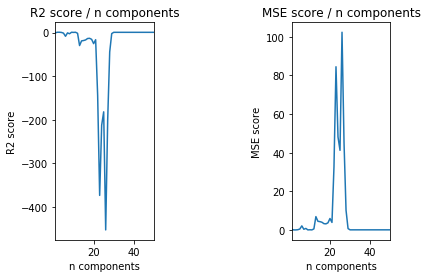

In [40]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

The n components with the maximum R2 score and the minimum MSE score are to be used as the suitable number of components for linear regression.

In [41]:
r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 2 R2 score: 0.63701169986851
Best n: 2 MSE: 0.08189356219776432


In [42]:
# Use the best n_components parameter
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lr.fit(X_train, y_train)

# check the result
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print("MSE:", mse)

R2 score: 0.63701169986851
MSE: 0.08189356219776432


In [43]:
# Let's try to project the coefs back to the original number of features
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lr.coef_

pcr_coefs.shape

(246,)

In [44]:
# Let's check which venue types effect the most and least
print('Max positive coefs:', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('Venue types with most positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)
print('Max negative coefs:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)
coef_abs = abs(pcr_coefs)
print('Min coefs:', pcr_coefs[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

Max positive coefs: [0.03109502 0.02964154 0.02898049 0.02737226 0.02737226 0.02737226
 0.02737226 0.02737226 0.02737226 0.02737226]
Venue types with most positive effect: ['Modern European Restaurant' 'French Restaurant' 'Steakhouse'
 'Boxing Gym' 'Botanical Garden' 'Event Space' 'Butcher'
 'Business Service' 'Church' 'Whisky Bar']
Max negative coefs: [-0.00802054 -0.00783563 -0.00729372 -0.00696376 -0.00645303 -0.00617345
 -0.00579528 -0.00569817 -0.00536403 -0.00493304]
Venue types with most negative effect: ['Bus Stop' 'Fast Food Restaurant' 'Train Station' 'Warehouse Store'
 'Soccer Field' 'Video Game Store' 'Shopping Mall'
 'Furniture / Home Store' 'Metro Station' 'Gas Station']
Min coefs: [-2.45678768e-05  9.31922052e-05  9.31922052e-05 -9.48316924e-05
 -1.57587259e-04  2.48611641e-04  2.56906690e-04 -3.84620366e-04
  4.08292922e-04 -5.20491720e-04]
Venue types with least effect: ['Organic Grocery' 'Skate Park' 'Pakistani Restaurant' 'Discount Store'
 'Social Club' 'Dim Sum Rest

## D. Conclusion

The R2 score isn't very close to 1 which shows that the machine learning technique of Linear Regression is not the most suitable way of presenting a very viable conclusion about the correlation between surrounding venues and the avg rent in neighborhoods.<br>
But according to our analysis, for a "2 bedroom apartment" we have the following observations: <br>
1. Restaurants have the most impact on the rent price. The areas where such restaurants are within 1km of range, the prices are seen to be very high.
2. Regions with a bus stop or train station are seen to be cheaper for the rent is relatively low in there.
3. Organic groceries, skate parks, pakistani restaurants, Soccer Stadiums, Discount Store and Social Clubs do not have a major impact on the rent prices.
